In [4]:
import numpy as np
import pandas as pd
# from rootpyPickler import Unpickler
# import shipLHC_conf as sndDet_conf
# import SndlhcGeo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
from scipy import stats

In [5]:
simps_x = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_x_{}.txt".format(station))
    simps_x.append(data)

In [6]:
simps_y = []
for station in range(1,6):
    data = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_y_{}.txt".format(station))
    simps_y.append(data)

In [7]:
# energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
depths = [291,295,304,308,317,321,330,334,343,347]
PDFs_x = []

for depth in depths:
    for station in range(1,6):
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_x_{}.txt".format(depth,station)
        data = np.loadtxt(path)
        PDFs_x.append(data)

In [8]:
# energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
depths = [291,295,304,308,317,321,330,334,343,347]
PDFs_y = []

for depth in depths:
    for station in range(1,6):
        path = "/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_y_{}.txt".format(depth,station)
        data = np.loadtxt(path)
        PDFs_y.append(data)

In [9]:
PDFs_x = np.array(PDFs_x)

In [10]:
PDFs_x += 0.00005

In [11]:
PDFs_y = np.array(PDFs_y)

In [12]:
PDFs_y += 0.00005

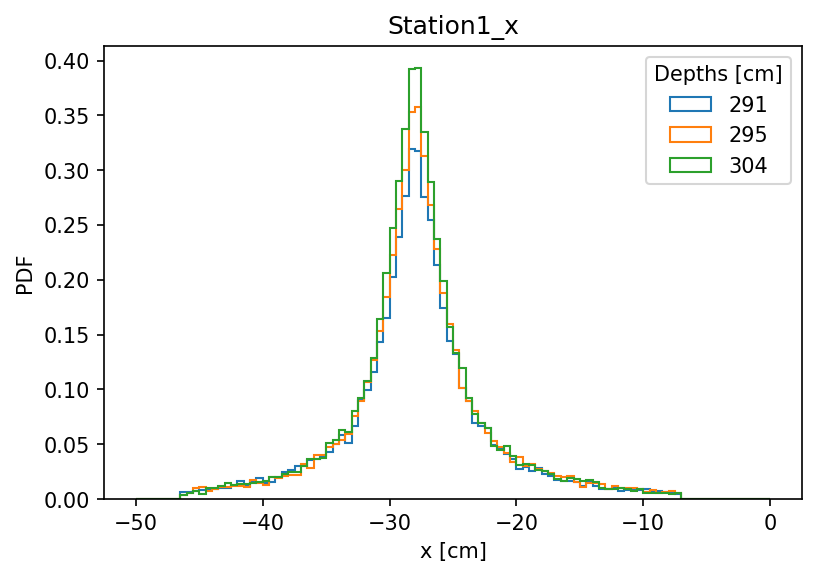

In [13]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for depth in [291,295,304]:#,308,317,321,330,334,343,347]:
    PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/PDF_x_5.txt".format(depth))
    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF,histtype="step",
                        label=[str(depth)])

plt.xlabel("x [cm]")
plt.ylabel("PDF")
plt.title("Station1_x")
plt.legend(title="Depths [cm]")

# plt.savefig("station1_x_energies.png")
plt.show()

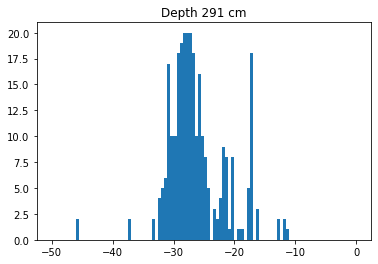

In [14]:
energy = 300
for true_z in [291]:
    hit_counts_x_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/events/hits_x.txt".format(true_z,energy))
    hit_counts_x_list = hit_counts_x_list.values.tolist()
    
    hit_counts_y_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/events/hits_y.txt".format(true_z,energy))
    hit_counts_y_list = hit_counts_y_list.values.tolist()
    
    plt.hist(np.linspace(-49.75,-0.25,100),bins = np.linspace(-50,0,101),weights=hit_counts_x_list[5])
    plt.title("Depth {} cm".format(true_z))
    plt.show()

In [15]:
hit_counts_x_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_317/pions_300/PDF/events/hits_x.txt")
hit_counts_x_list = hit_counts_x_list.values.tolist()

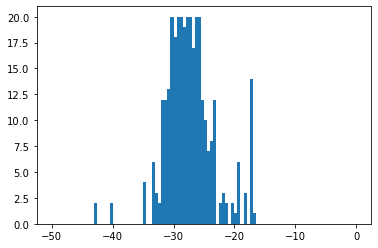

In [16]:
plt.hist(np.linspace(-49.75,-0.25,100),bins=np.linspace(-50,0,101),weights=hit_counts_x_list[2+90])
plt.show()

In [29]:
t1 = time.perf_counter()
r2_vals = []

depths = [291,295,304,308,317,321,330,334,343,347]
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

logL_x_list = []

for energy in [100]:
    reco_z_x_corrs = []
    for correction in [-50]:
        reco_z_x = np.array([])
        reco_z_y = np.array([])
        reco_z_comb = np.array([])        

        for true_z_num, true_z in enumerate(depths):
            hit_counts_x_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_{}/PDF/events/hits_x.txt".format(true_z,energy))
            hit_counts_x_list = hit_counts_x_list.values.tolist()
            
            for event in range(1,101):

                sum_log_x = np.zeros(10)

                for depth_num, starting_depth in enumerate(depths):

                    logL_x = 0
                    
                    for station in range(1,6):

                        SiPM_counts_x = simps_x[station-1]

                        hit_counts_x = hit_counts_x_list[(5*(event-1))+(station-1)]


                        PDF_x = PDFs_x[(depth_num*5)+(station-1)]

                        logL_x += np.sum(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                                            ((hit_counts_x)*np.log(PDF_x)))
                         
                        logL_x_list.append(np.sum(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                                            ((hit_counts_x)*np.log(PDF_x))))
            
                    sum_log_x[depth_num] = logL_x
                    

                reco_z_x = np.append(reco_z_x,depths[np.argmax(sum_log_x)])
               
        reco_z_x_corrs.append(reco_z_x)

    reco_z_x_df = pd.DataFrame(reco_z_x_corrs)   

    reco_z_x_df.to_csv("/eos/user/s/skatsaro/PGsim/reco_depth_e_{}/reco_z_x.txt".format(energy), encoding="utf-8", index=False)

    t2 = time.perf_counter()
print(t2-t1)

18.567553129978478


In [15]:
depths = [291,295,304,308,317,321,330,334,343,347]
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
resolution = []
stds = []
for energy in energies:
    
    reco_z_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/reco_depth_e_{}/reco_z_x.txt".format(energy))
    reco_z_x = np.ndarray.flatten(reco_z_x.values)
    reco_avg = np.average(reco_z_x.reshape(10,100),axis=1)
    reco_std = np.std(reco_z_x.reshape(10,100),axis=1)
    delta_z = reco_avg-depths
    resolution.append(abs(delta_z/depths))
#     stds.append(reco_std)

In [10]:
true_z = np.array([])
for z in depths:
    for i in range(0,100):
    
        true_z = np.append(true_z,z)

In [42]:
depths = [291,295,304,308,317,321,330,334,343,347]
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
bias = []
res = []
for energy in energies:
    
    reco_z_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/reco_depth_e_{}/reco_z_x.txt".format(energy))
    reco_z_x = np.ndarray.flatten(reco_z_x.values)
#     reco_avg = np.average(reco_e_x.reshape(11,100),axis=1)
#     reco_std = np.std(reco_e_x.reshape(11,100),axis=1)
    
    bias_z = np.average(((reco_z_x-true_z)/true_z).reshape(10,100),axis=1)
    res_z = np.std(((reco_z_x-true_z)/true_z).reshape(10,100),axis=1)
    bias.append(bias_z)
    res.append(res_z)
#     resolution.append(reco_std)

In [16]:
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [223]:
reco_z_x = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/reco_depth_e_750/reco_z_x.txt")
reco_z_x = np.ndarray.flatten(reco_z_x.values)
reco_avg = np.average(reco_z_x.reshape(10,100),axis=1)
delta_z = reco_avg-depths

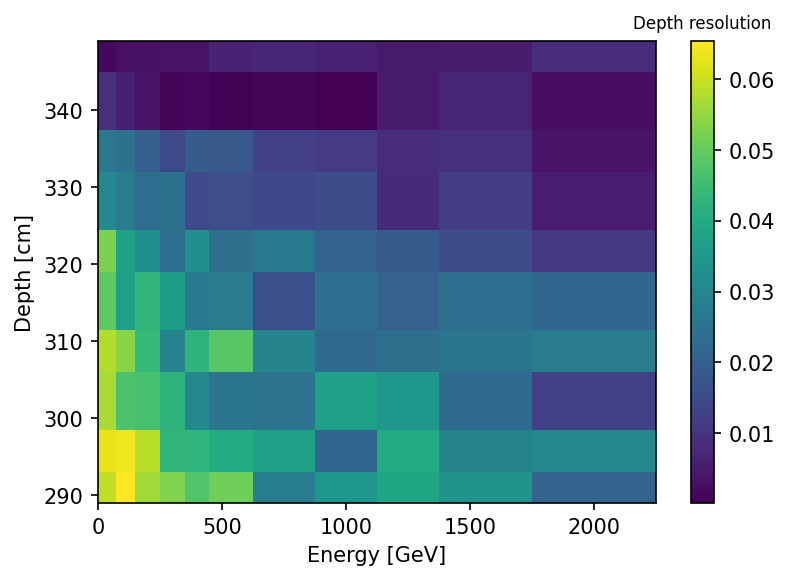

In [19]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
bins = [289,293,298.5,306,311.5,319,324.5,332,337.5,345,349]

# norm = TwoSlopeNorm(vmin=np.min(resolution), vcenter=0, vmax=np.max(resolution))

plt.hist2d(np.repeat(energies,10),np.tile(depths,11),bins = [[0,75,150,250,350,450,625,875,1125,1375,1750,2250],bins],
                                                             weights=np.ndarray.flatten(np.array(resolution)))
# plt.xticks(np.linspace(1,5.5,10))
plt.xlabel("Energy [GeV]")
plt.ylabel("Depth [cm]")
# plt.set_cmap('viridis') 
clb = plt.colorbar(ax=ax)
clb.ax.set_title("Depth resolution", fontsize=8)
# plt.savefig("Resolution reco depth, all depths and energies.png",bbox_inches="tight")

plt.show()

In [172]:
resolution = np.array(resolution)

In [24]:
deltas = np.array(deltas)

In [44]:
res = np.array(res)

In [45]:
bias = np.array(bias)

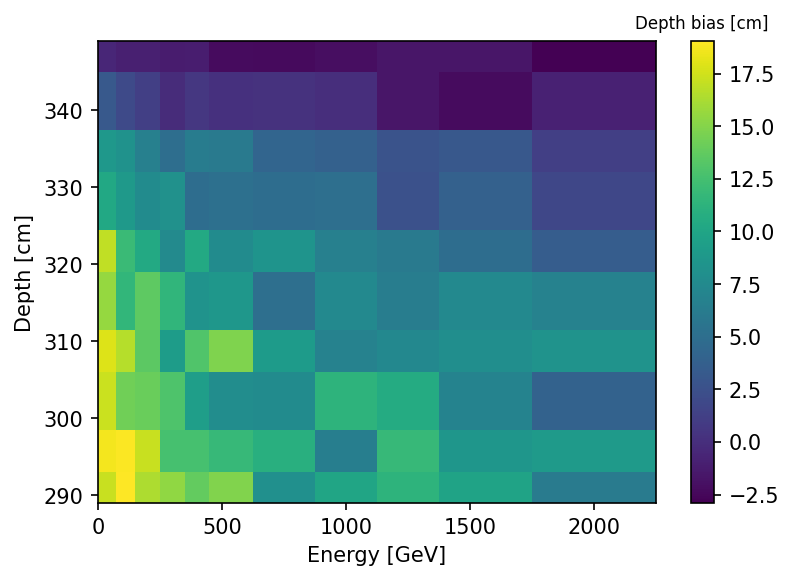

In [41]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
bins = [289,293,298.5,306,311.5,319,324.5,332,337.5,345,349]

# norm = TwoSlopeNorm(vmin=np.min(resolution), vcenter=0, vmax=np.max(resolution))

plt.hist2d(np.repeat(energies,10),np.tile(depths,11),bins = [[0,75,150,250,350,450,625,875,1125,1375,1750,2250],bins],
                                                             weights=np.ndarray.flatten(np.array(bias)))
# plt.xticks(np.linspace(1,5.5,10))
plt.xlabel("Energy [GeV]")
plt.ylabel("Depth [cm]")
# plt.set_cmap('viridis') 
clb = plt.colorbar(ax=ax)
clb.ax.set_title("Depth bias [cm]", fontsize=8)
# plt.savefig("Bias reco depth, all depths and energies (updated,absolute).png",bbox_inches="tight")

plt.show()

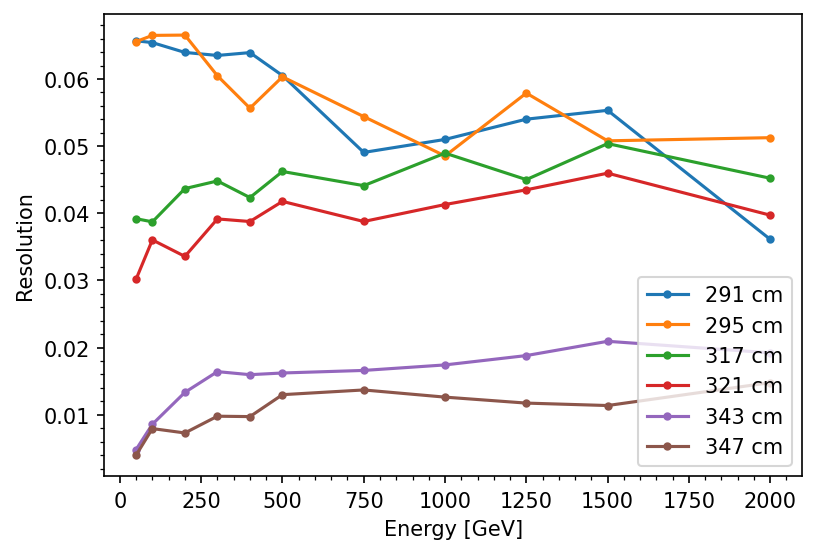

In [52]:
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
# energies_sub = [50,300,750,1250,2000]

depth_sub = [291,295,317,321,343,347]
legend_depth = [str(x) + " cm" for x in depth_sub]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for num_z, depth in enumerate(depth_sub):
    

    plt.plot(energies,res[:,np.where(np.array(depths)==depth)[0]],marker=".")
#     plt.errorbar(depths,deltas[:,num_e],yerr=stds[:,num_e]/2,linestyle="")
    plt.xlabel("Energy [GeV]")
    plt.ylabel("Resolution")
    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
#     plt.title("Energy reco. {} GeV".format(energy))
    
plt.legend(legend_depth)
# plt.savefig("Res reco depth, [291, 295, 317, 321, 343, 347] cm, all energies (updated).png",bbox_inches="tight")
plt.show()

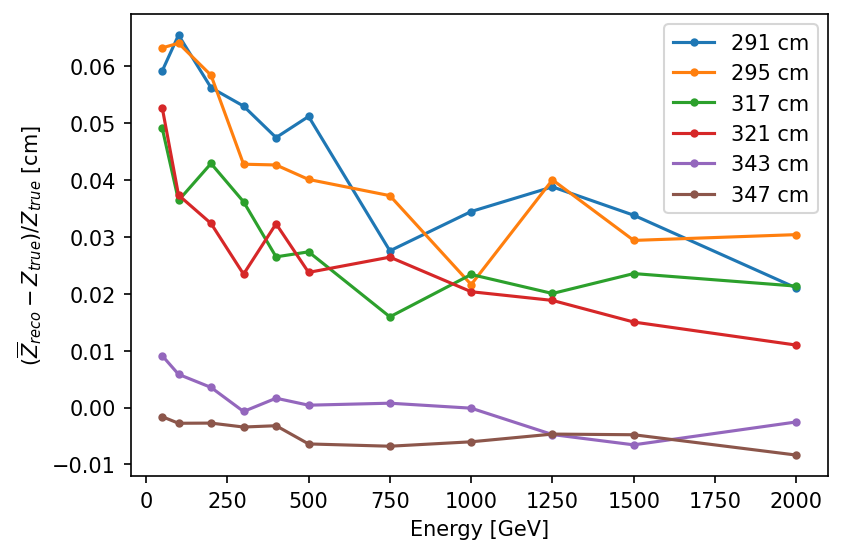

In [178]:
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
# energies_sub = [50,300,750,1250,2000]

depth_sub = [291,295,317,321,343,347]
legend_depth = [str(x) + " cm" for x in depth_sub]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for num_z, depth in enumerate(depth_sub):
    

    plt.plot(energies,resolution[:,np.where(np.array(depths)==depth)[0]],marker=".")
#     plt.errorbar(depths,deltas[:,num_e],yerr=stds[:,num_e]/2,linestyle="")
    plt.xlabel("Energy [GeV]")
    plt.ylabel("$(\overline{Z}_{reco}-Z_{true})/Z_{true}$ [cm]")
#     plt.title("Energy reco. {} GeV".format(energy))
    
plt.legend(legend_depth)
# plt.savefig("Resolution reco depth, [291, 295, 317, 321, 343, 347] cm, all energies.png",bbox_inches="tight")
plt.show()

In [73]:
t1 = time.perf_counter()
reco_z_x = np.array([])
reco_z_y = np.array([])
reco_z_comb = np.array([])
# energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
depths = [291,295,304,308,317,321,330,334,343,347]


for true_z in depths:
    hit_counts_x_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/events/hits_x.txt".format(true_z))
    hit_counts_x_list = hit_counts_x_list.values.tolist()
    
    hit_counts_y_list = pd.read_csv("/eos/home-i02/s/skatsaro/PGsim/depth_{}/pions_300/PDF/events/hits_y.txt".format(true_z))
    hit_counts_y_list = hit_counts_y_list.values.tolist()
    for event in range(1,3):
        
        sum_log_x = np.zeros(5)
        sum_log_y = np.zeros(5)
#         sum_log_comb = np.zeros(11)


        for station in range(1,6):
            logL_x = []
            logL_y = []

            SiPM_counts_x = simps_x[station-1]

            hit_counts_x = hit_counts_x_list[(5*(event-1))+(station-1)]
    
            SiPM_counts_y = simps_y[station-1]
        
            hit_counts_y = hit_counts_y_list[(5*(event-1))+(station-1)]

#             print(SiPM_counts_x-SiPM_counts_y)
            for num_z, depth in enumerate(depths,start=0):
                
                PDF_x = PDFs_x[((station-1)*5)+num_z]

                logL_x.append(np.sum(np.nan_to_num(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                       ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
    
                PDF_y = PDFs_y[((station-1)*5)+num_z]

                logL_y.append(np.sum(np.nan_to_num(((SiPM_counts_y-hit_counts_y)*np.log(1-PDF_y))+\
                                                       ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))
            
            print(logL_x)
            
            sum_log_x += logL_x
            sum_log_y += logL_y
#         print(sum_log_x)
        reco_z_x = np.append(reco_z_x,depths[np.argmax(sum_log_x)])
        reco_z_y = np.append(reco_z_y,depths[np.argmax(sum_log_y)])
        reco_z_comb = np.append(reco_z_comb,depths[np.argmax(sum_log_y+sum_log_x)])

t2 = time.perf_counter()
print(t2-t1)

<ipython-input-73-78576ff08e9b>:40: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:45: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:40: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:45: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:40: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:45: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:40: RuntimeWarning: divide by zero encounter

[-642.734352937847, -905.7440116131108, -1901.4003736474233, -1570.359683039032, -643.1002332606823]
[-179.61437381328312, -54.78139595870188, 0.0, -62.85367004018897, -0.020010006671670688]
[-168.98359636699809, -186.52911623610095, -153.52350669698376, -136.00154191928243, -145.94252338819953]
[-113.81163549269877, -89.18191770870035, -42.96642162139389, -0.17044488018549528, 0.0]
[-247.6470743362778, -263.8915821666725, -250.2004247692293, -267.4581760007308, -243.4933654028087]
[-603.875981116264, -810.6668078875863, -1510.7982463942799, -1512.2054218263108, -595.4096941416517]
[-583.3411167092377, -68.70037726017593, 0.0, -62.211342108025235, -0.020010006671670688]
[-312.9138246809865, -313.92914706684394, -303.45928596876735, -323.1480091110045, -502.20082108407337]
[-399.4302810935093, -137.85352844617628, -149.27371903589102, -0.17044488018549528, 0.0]
[-287.55020425960606, -300.76668872969896, -277.19577469038836, -317.7260658732047, -285.7168721039677]
[-121.04337982721029, -

<ipython-input-73-78576ff08e9b>:40: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-73-78576ff08e9b>:45: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))


In [30]:
true_z = np.array([])
for z in depths:
    for i in range(0,100):
    
        true_z = np.append(true_z,z)

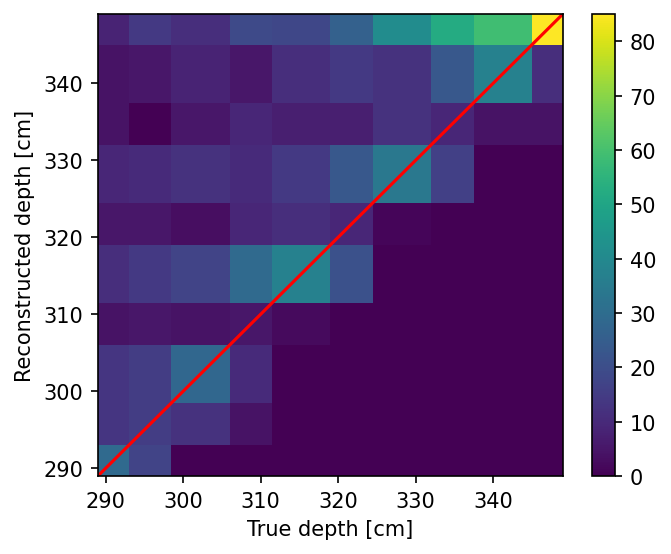

In [33]:
bins = [289,293,298.5,306,311.5,319,324.5,332,337.5,345,349]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_z,np.ndarray.flatten(np.array(reco_z_x)),bins = [bins,bins])
plt.ylabel("Reconstructed depth [cm]")
plt.xlabel("True depth [cm]")

# plt.colorbar(title="Number of events")
plt.colorbar()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")

# plt.tight_layout()
# plt.savefig("Depth_reco_e_100(100 events per e), x only(correction=0.00005)(diagonal).png",bbox_inches="tight")
# plt.xticks(energies)
# plt.yticks(energies)
plt.show()

In [269]:
deltas = np.array(deltas)

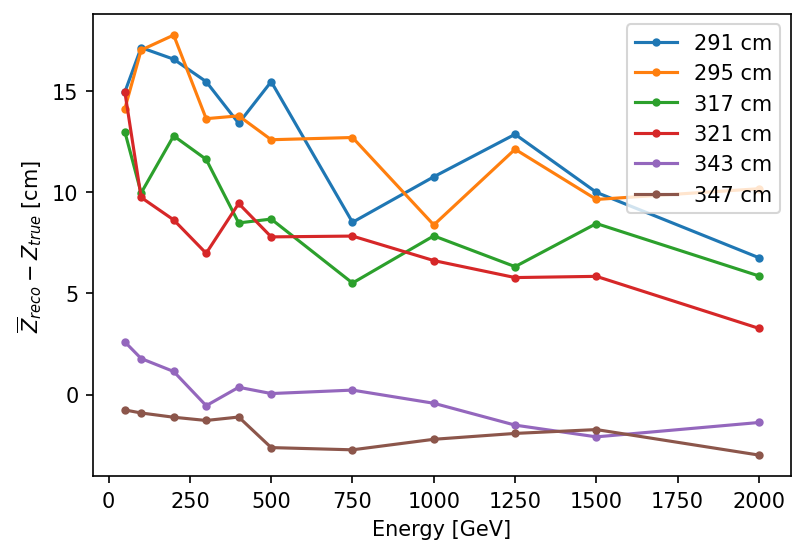

In [274]:
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]
# energies_sub = [50,300,750,1250,2000]

depth_sub = [291,295,317,321,343,347]
legend_depth = [str(x) + " cm" for x in depth_sub]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for num_z, depth in enumerate(depth_sub):
    

    plt.plot(energies,deltas[:,np.where(np.array(depths)==depth)[0]],marker=".")
#     plt.errorbar(depths,deltas[:,num_e],yerr=stds[:,num_e]/2,linestyle="")
    plt.xlabel("Energy [GeV]")
    plt.ylabel("$\overline{Z}_{reco}-Z_{true}$ [cm]")
#     plt.title("Energy reco. {} GeV".format(energy))
    
plt.legend(legend_depth)
plt.savefig("Delta reco depth, [291, 295, 317, 321, 343, 347] cm, all energies.png",bbox_inches="tight")
plt.show()

In [6]:
t1 = time.perf_counter()
reco_e_x = np.array([])
reco_e_y = np.array([])
reco_e_comb = np.array([])
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]



for true_e in energies:
    for event in range(1,101):
        
        sum_log_x = np.zeros(11)
        sum_log_y = np.zeros(11)
        sum_log_comb = np.zeros(11)


        for station in range(1,6):
            logL_x = []
            logL_y = []
#             logL_comb = np.array([])

            SiPM_counts_x = simps_x[station-1]

            hit_counts_x = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_304/pions_{}/PDF/events/hits_x_{}_{}.txt".format(true_e,station,event))

            SiPM_counts_y = simps_y[station-1]

            hit_counts_y = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_304/pions_{}/PDF/events/hits_y_{}_{}.txt".format(true_e,station,event))
            
            for num_e, energy in enumerate(energies,start=0):
                
                PDF_x = PDFs_x[((station-1)*11)+num_e]
#                 print(np.sum(PDF))
                logL_x.append(np.sum(np.nan_to_num(((SiPM_counts_x-hit_counts_x)*np.log(1-PDF_x))+\
                                                       ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
    
                PDF_y = PDFs_y[((station-1)*11)+num_e]
#                 print(np.sum(PDF))
                logL_y.append(np.sum(np.nan_to_num(((SiPM_counts_y-hit_counts_y)*np.log(1-PDF_y))+\
                                                       ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))
                #print(logL)
#                 print(PDF)
#             plt.scatter([50,100,200,300,400,500,750,1000,1250,1500,2000],logL,label = station)
            sum_log_x += logL_x
            sum_log_y += logL_y
#             sum_log_comb += (sum_log_x + sum_log_y)
#             print(logL)
        reco_e_x = np.append(reco_e_x,energies[np.argmax(sum_log_x)])
        reco_e_y = np.append(reco_e_y,energies[np.argmax(sum_log_y)])
        reco_e_comb = np.append(reco_e_comb,energies[np.argmax(sum_log_y+sum_log_x)])
        
t2 = time.perf_counter()
print(t2-t1)

<ipython-input-6-4c26e314f360>:36: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_x)*np.nan_to_num(np.log(PDF_x),neginf=0)),nan=0.0)))
<ipython-input-6-4c26e314f360>:41: RuntimeWarning: divide by zero encountered in log
  ((hit_counts_y)*np.nan_to_num(np.log(PDF_y),neginf=0)),nan=0.0)))


754.7899839077145


In [50]:
# _, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
reco_e = np.array([])
energies = [50,100,200,300,400,500,750,1000,1250,1500,2000]

for true_e in [2000]:

    sum_log_indiv = []
        
#     sum_log = np.zeros(11)
    for station in range(1,6):
        logL = np.array([])
        SiPM_counts = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/SiPMs/SiPM_x_{}.txt".format(station))

        hit_counts = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/events/hits_x_{}_1.txt".format(true_e,station))
#             print(hit_counts)
        for energy in energies:

            PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_x_{}.txt".format(energy,station))
#                 print(np.sum(PDF))
            logL = np.append(logL,np.sum(np.nan_to_num(((SiPM_counts-hit_counts)*np.log(1-PDF))+\
                                                       ((hit_counts)*np.nan_to_num(np.log(PDF),neginf=0)),nan=0.0)))
            
            #print(logL)
#                 print(PDF)
#             plt.scatter([50,100,200,300,400,500,750,1000,1250,1500,2000],logL,label = station)
        sum_log_indiv.append(logL)
#         sum_log += logL
        print(logL)
    sum_log = np.sum(np.array(sum_log_indiv),axis=0)
#             print(logL)
    print(sum_log)
    reco_e = np.append(reco_e,energies[np.argmax(sum_log)])

            
    
# plt.legend(title="Station")
# plt.show()
# plt.xlabel("x [cm]")
# plt.ylabel("Count / 0.5 cm")
# plt.title("Station1_x")
# plt.legend(title="Plane")

# # plt.savefig("station1_x_energies.png")
# plt.show()

<ipython-input-50-0b72a5a984ba>:21: RuntimeWarning: divide by zero encountered in log
  ((hit_counts)*np.nan_to_num(np.log(PDF),neginf=0)),nan=0.0)))


[ -58.38328389  -81.29044431  -88.99661991 -141.68130655 -151.23405688
 -142.62153677 -228.70501409 -204.52051747 -162.24360728 -121.74006159
 -113.88540455]
[-283.33308078 -339.89971995 -351.06928071 -354.73780524 -355.73338524
 -362.64698496 -421.45085839 -453.39673418 -346.39959218 -365.86712012
 -352.24890969]
[-1534.59915064 -1322.46675082 -1101.94466433  -975.24642949
  -927.27601401  -831.99088082  -747.16439257  -639.027776
  -819.9406768   -844.36948541  -797.31119713]
[-1805.49199447 -1513.69605777 -1235.53079765 -1072.57548735
 -1053.62109622  -953.68347823  -862.3315268   -782.26144406
  -951.77566781  -979.09661109  -854.88066163]
[-1823.97600371 -1473.92227619 -1187.96806118 -1076.67840122
  -953.62903115  -895.92345609  -850.53463813  -682.33904382
  -903.28684479  -873.84320359  -761.22200991]
[-5505.78351349 -4731.27524903 -3965.50942379 -3620.91942985
 -3441.4935835  -3186.86633687 -3110.18642998 -2761.54551552
 -3183.64638887 -3184.91648181 -2879.54818291]


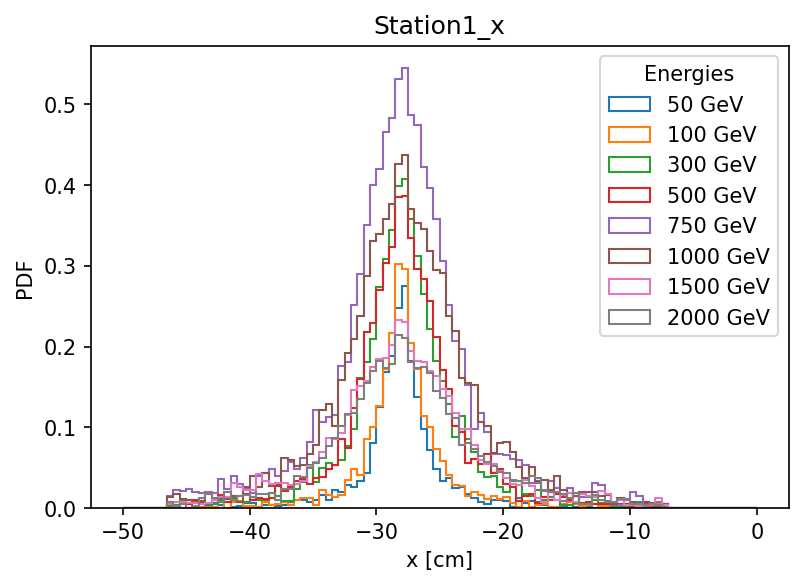

In [20]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for energy in [50,100,300,500,750,1000,1500,2000]:
    PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_x_1.txt".format(energy))
    PDF_bins = plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=PDF,histtype="step",
                        label=[str(energy)+" GeV"])

plt.xlabel("x [cm]")
plt.ylabel("PDF")
plt.title("Station1_x")
plt.legend(title="Energies")

# plt.savefig("station1_x_energies.png")
plt.show()

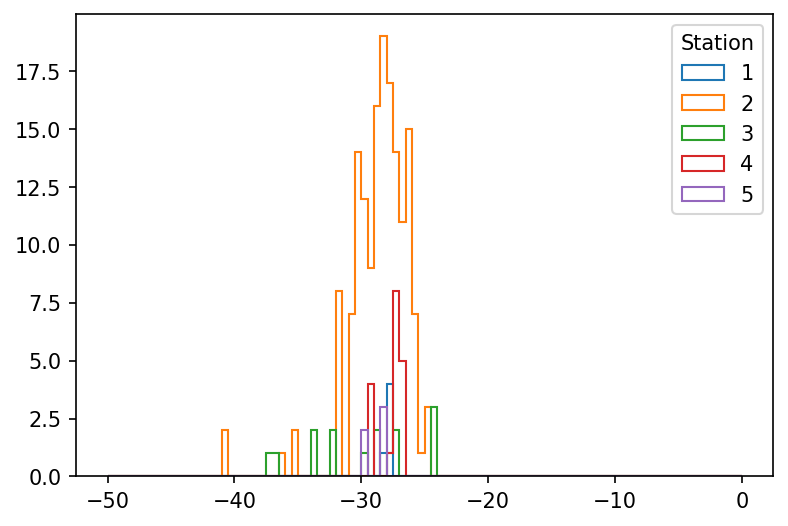

In [33]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

for station in range(1,6):

    hit_counts = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/events/hits_x_{}_{}.txt"\
                            .format(50,station,12))

    plt.hist(np.linspace(-50,0,100),bins=np.linspace(-50,0,101),weights=hit_counts,histtype="step",label=station)
    
plt.legend(title="Station")
plt.savefig("50 GeV hits(evt_12).png")
plt.show()

In [ ]:
PDF = np.loadtxt("/eos/home-i02/s/skatsaro/PGsim/depth_291/pions_{}/PDF/PDF_x_{}.txt".format(energy,station))
logL = np.append(logL,np.sum(np.nan_to_num(((SiPM_counts-hit_counts)*np.log(1-PDF))+\
                                           ((hit_counts)*np.nan_to_num(np.log(PDF),neginf=0)),nan=0.0)))

In [22]:
true_e = np.array([])
for e in energies:
    for i in range(0,100):
    
        true_e = np.append(true_e,e)

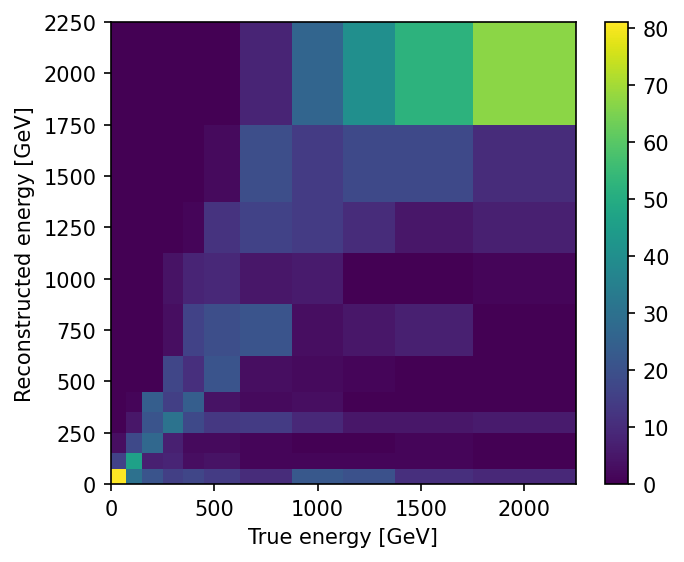

In [27]:
bins = [0,75,150,250,350,450,625,875,1125,1375,1750,2250]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_e,reco_e_x,bins = [bins,bins])
plt.ylabel("Reconstructed energy [GeV]")
plt.xlabel("True energy [GeV]")

# plt.colorbar(title="Number of events")
plt.colorbar()

# plt.tight_layout()
# plt.savefig("Energy_reco_z_304(100 events per e), x only.png",bbox_inches="tight")
# plt.xticks(energies)
# plt.yticks(energies)
plt.show()

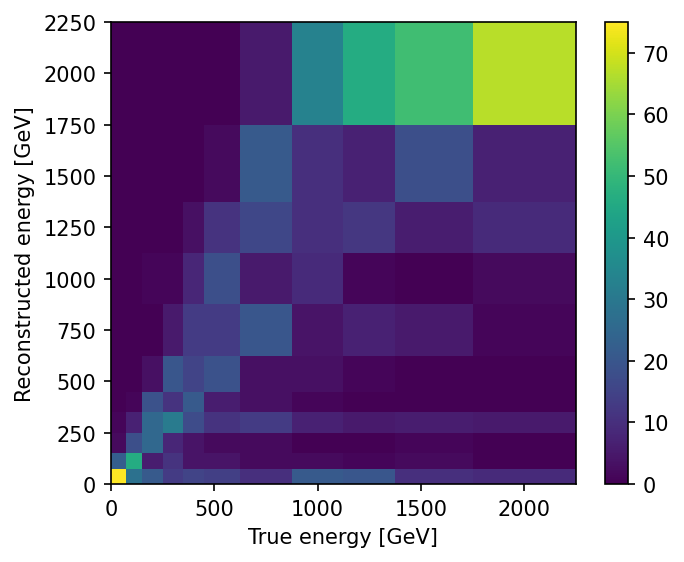

In [28]:
bins = [0,75,150,250,350,450,625,875,1125,1375,1750,2250]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_e,reco_e_y,bins = [bins,bins])
plt.ylabel("Reconstructed energy [GeV]")
plt.xlabel("True energy [GeV]")

# plt.colorbar(title="Number of events")
plt.colorbar()

# plt.tight_layout()
# plt.savefig("Energy_reco_z_291(100 events per energy).png",bbox_inches="tight")
# plt.savefig("Energy_reco_z_304(100 events per e), y only.png",bbox_inches="tight")

# plt.xticks(energies)
# plt.yticks(energies)
plt.show()

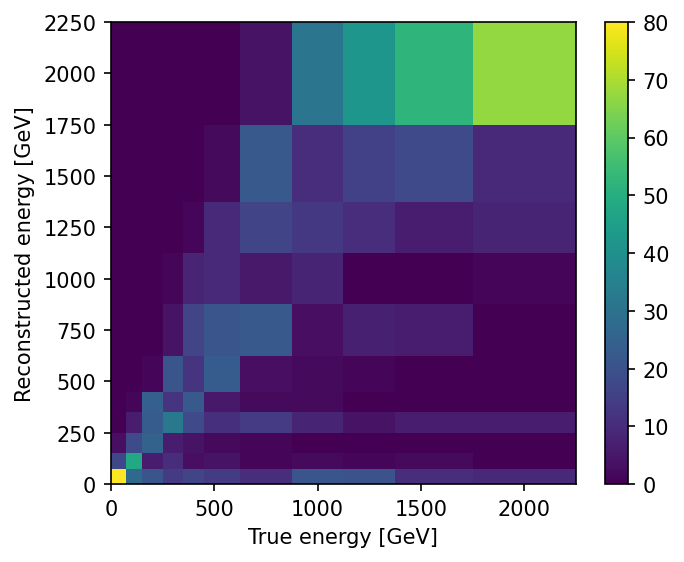

In [29]:
bins = [0,75,150,250,350,450,625,875,1125,1375,1750,2250]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), dpi=150)
plt.hist2d(true_e,reco_e_comb,bins = [bins,bins])
plt.ylabel("Reconstructed energy [GeV]")
plt.xlabel("True energy [GeV]")

# plt.colorbar(title="Number of events")
plt.colorbar()

# plt.tight_layout()
# plt.savefig("Energy_reco_z_291(100 events per energy).png",bbox_inches="tight")
# plt.savefig("Energy_reco_z_304(100 events per e), x and y combined.png",bbox_inches="tight")

# plt.xticks(energies)
# plt.yticks(energies)
plt.show()

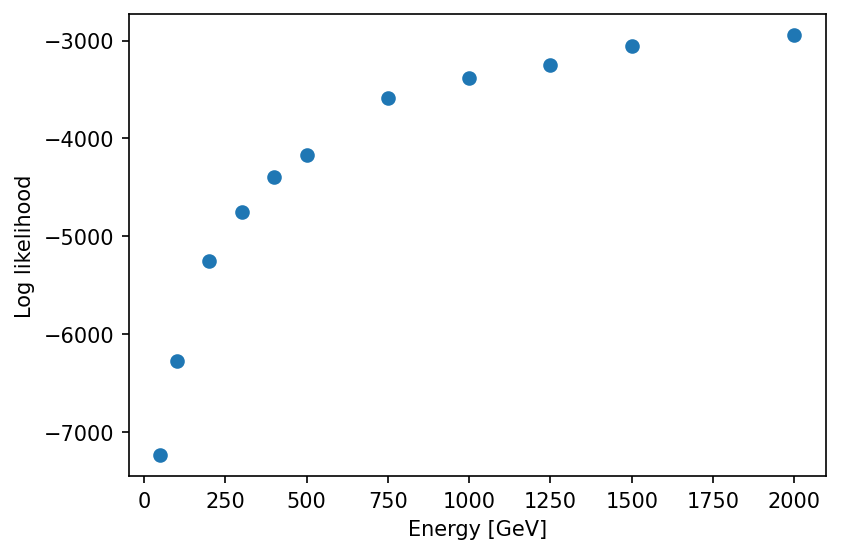

In [20]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

plt.scatter([50,100,200,300,400,500,750,1000,1250,1500,2000],sum_log)
plt.ylabel("Log likelihood")
plt.xlabel("Energy [GeV]")
# plt.legend(title="Station")
plt.show()

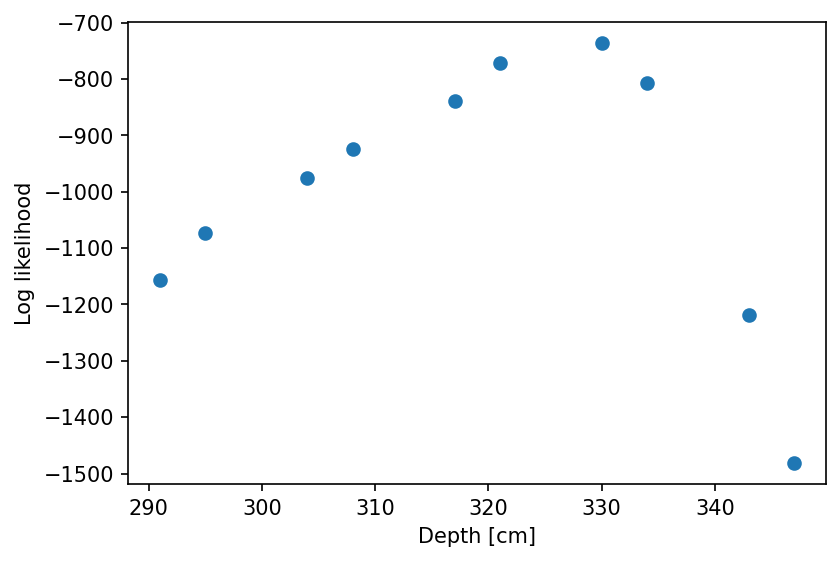

In [140]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

plt.scatter(depths,sum_log_x)
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
# plt.legend(title="Station")
# plt.savefig("combined logL for 304cm 300 GeV example (depth reco)(evt_2).png",bbox_inches="tight")
plt.show()

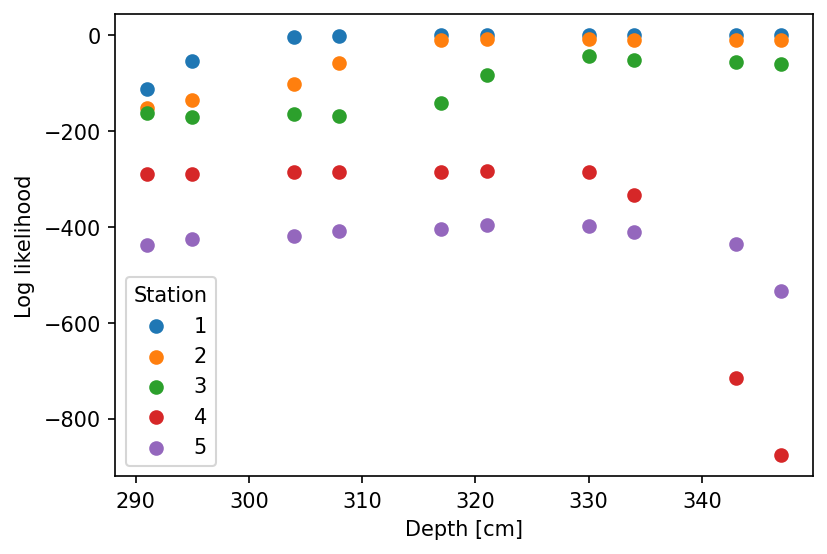

In [142]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for i in range(0,5):

    plt.scatter(depths,np.array(logL_x_list).reshape(10,5).T[i],label=i+1)
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
plt.legend(title="Station")
# plt.savefig("per station logL for 304cm 300 GeV example(depth reco)(evt_2).png",bbox_inches="tight")
plt.show()

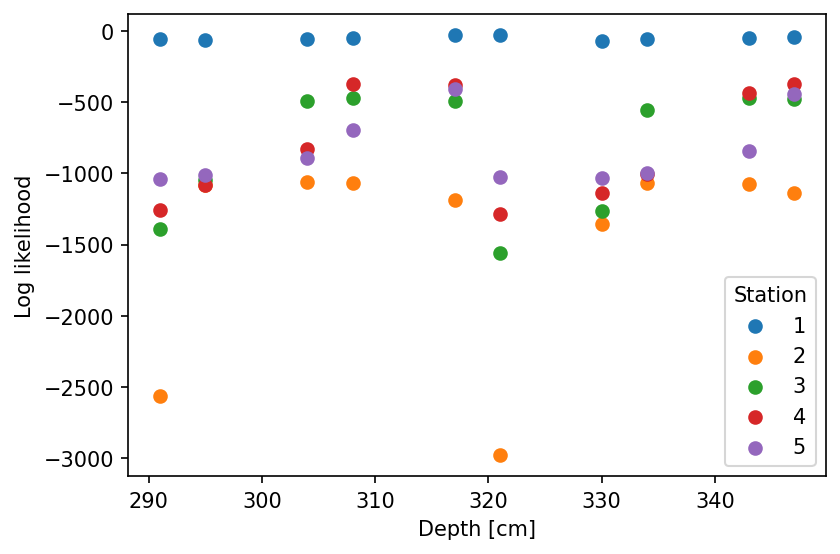

In [92]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)
for i in range(0,5):

    plt.scatter(depths,np.array(logL_x_list).reshape(5,10)[i],label=i+1)
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
plt.legend(title="Station")
# plt.savefig("per station logL for 304cm 300 GeV example(depth reco).png",bbox_inches="tight")
plt.show()

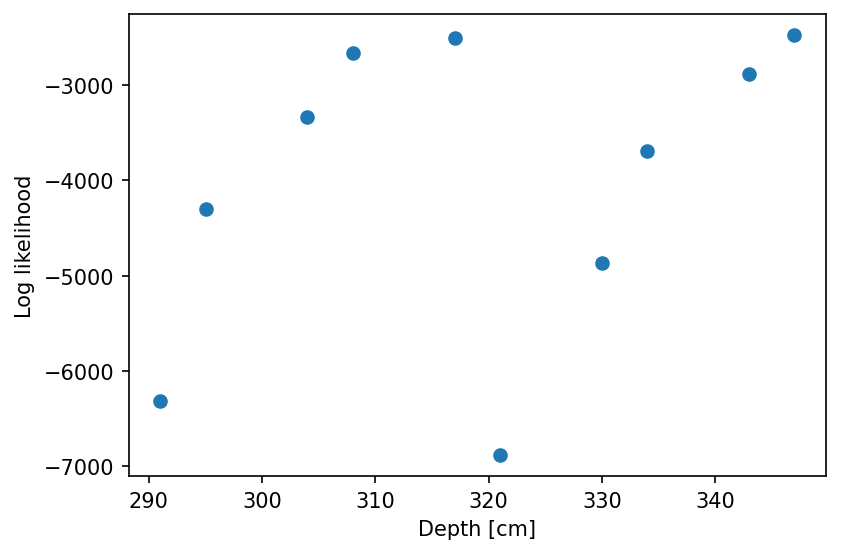

In [95]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=150)

plt.scatter(depths,np.sum(np.array(logL_x_list).reshape(5,10),axis=0))
plt.ylabel("Log likelihood")
plt.xlabel("Depth [cm]")
# plt.legend(title="Station")
# plt.savefig("combined logL for 304cm 300 GeV example (depth reco).png",bbox_inches="tight")
plt.show()